# Setup/Imports

In [1]:
import pickle
import keras
import tensorflow as tf
#from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers
import helpers.data_generator
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
from models.LSTMConv2D import get_model_lstm_conv2d, get_model_simple_lstm
from models.LSTMConv2D import get_model_linear_systems, get_model_conv2d
#from utils.callbacks import CyclicLR, TensorBoardWrapper
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm.notebook import tqdm
#import tkinter as tk
#from tkinter import filedialog
#root = tk.Tk()
#root.withdraw()

Using TensorFlow backend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wconlin/.conda/envs/tfg

In [2]:
#import importlib
#importlib.reload(helpers.normalization)

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 96
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'

color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

# Analysis

In [4]:
file_path='/home/jabbate/run_results_12_11/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5'
model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded model: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5
loaded dict: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12_params.pkl
with parameters: dict_keys(['excluded_shots', 'model_type', 'epochs', 'model_kwargs', 'input_profile_names', 'target_profile_names', 'actuator_names', 'scalar_input_names', 'batch_size', 'process_data', 'predict_deltas', 'lookahead', 'profile_downsample', 'std_activation', 'sample_weighting', 'hinge_weight', 'mse_weight_power', 'mse_weight_edge', 'mse_power', 'flattop_only', 'raw_data_path', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_

In [6]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [8]:
#import importlib
#importlib.reload(helpers.data_generator)
traindata, valdata, normalization_dict = helpers.data_generator.process_data('/scratch/gpfs/jabbate/old_stuff/test_data/final_data.pkl', #'/scratch/gpfs/jabbate/mixed_data/final_data.pkl',
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2,
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=['remove_nan','remove_dudtrip','remove_non_gas_feedback'],#scenario['pruning_functions'], #pruning_functions, 
                                                      #excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [])
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False) #scenario['shuffle_generators'])

Loading
Signals: bt, curr_target, dens, density_estimate, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  777
Number of shots used:  777
Total number of timesteps:  208845
Shots with Complete NaN: 
147621 samples total
Removing timesteps WITHOUT gas feedback
Removed 13153 samples
134468 samples remaining
Removing NaN
Removed 0 samples
134468 samples remaining
Removing dudtrip
Removed 1480 samples
132988 samples remaining
132988 samples remaining after pruning
Total number of samples:  132988
Number of training samples:  132988
Number of validation samples:  0


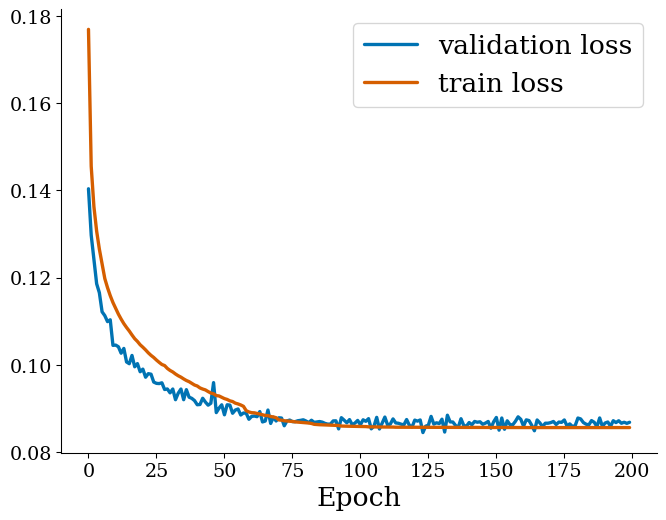

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(scenario['history']['val_loss'],label='validation loss')
ax.plot(scenario['history']['loss'],label='train loss')
ax.set_xlabel('Epoch', size=20)
ax.legend(fontsize=20)
#plt.ylim(0,.1)
fig.savefig('training.png')

In [8]:
denormed_traindata=helpers.normalization.denormalize(traindata.copy(),normalization_dict)

Denormalizing: 100%|##########| 19/19 [00:00<00:00, 38.19it/s]


In [16]:
def normalize(arr,signal):
    if scenario['predict_deltas']:
        return arr*normalization_dict[signal]['iqr']
    else:
        return helpers.normalization.denormalize_arr(arr,normalization_dict[signal])

In [17]:
sig_names={'curr_target': 'ip target (A)',
           'curr': 'ip (A)',
           'rotation': 'rotation (kHz)',
           'bt': 'Bt (T)',
       'temp':'Te (keV)', 
       'dens': 'ne (10^19 m^-3)',
       'q_EFIT01':'q EFIT01',
       'pinj': 'pinj (kW)', 
       'gasA': 'gasA (V)',
       'tinj':'tinj (Nm)',
       'target_density': 'target <ne> (10^19 m^-3)',
          'press_EFIT01': 'Pressure EFIT01 (N/m^2)'}
sig_lims={'rotation': [0,200],
          'bt': [-10,10],
          'thomson_temp_EFITRT1': [0,2e3],             
          'curr': [0,3e6],
          'curr_target': [0,3e6],
          'temp':[0,10], 
          'dens': [0,10],
          'pinj': [0,1.5e4],
          'tinj':[0,10],
          'target_density': [0,8],
          'gasA': [0,10]}

In [18]:
psi = np.linspace(0,1,scenario['profile_length'])

# Run the below cell to get PCA components #

In [19]:
from sklearn import preprocessing
from sklearn import decomposition

profiles=scenario['target_profile_names']
psi = np.linspace(0,1,scenario['profile_length'])

pca_fitter={}

num_samples=1000
num_components=3


pre_pca={profile: [] for profile in profiles}

k=0
while k<num_samples:
    index=np.random.choice(len(train_generator))
    sample=train_generator[index]
    
    inputs=sample[0]
    targets=sample[1]
    
    for profile in profiles:
#         this_input=inputs['input_{}'.format(profile)][0][0]
        this_input=targets['target_{}'.format(profile)][0]

        pre_pca[profile].append(this_input)
        #target=targets['target_{}'.format(profile)][0]
        #pre_pca[profile].append(target)
        #pre_pca[profile].append(normalize(target,profile))
        
    k+=1
    
for profile in profiles:
    pca_fitter[profile]=decomposition.PCA(n_components=num_components).fit(pre_pca[profile])



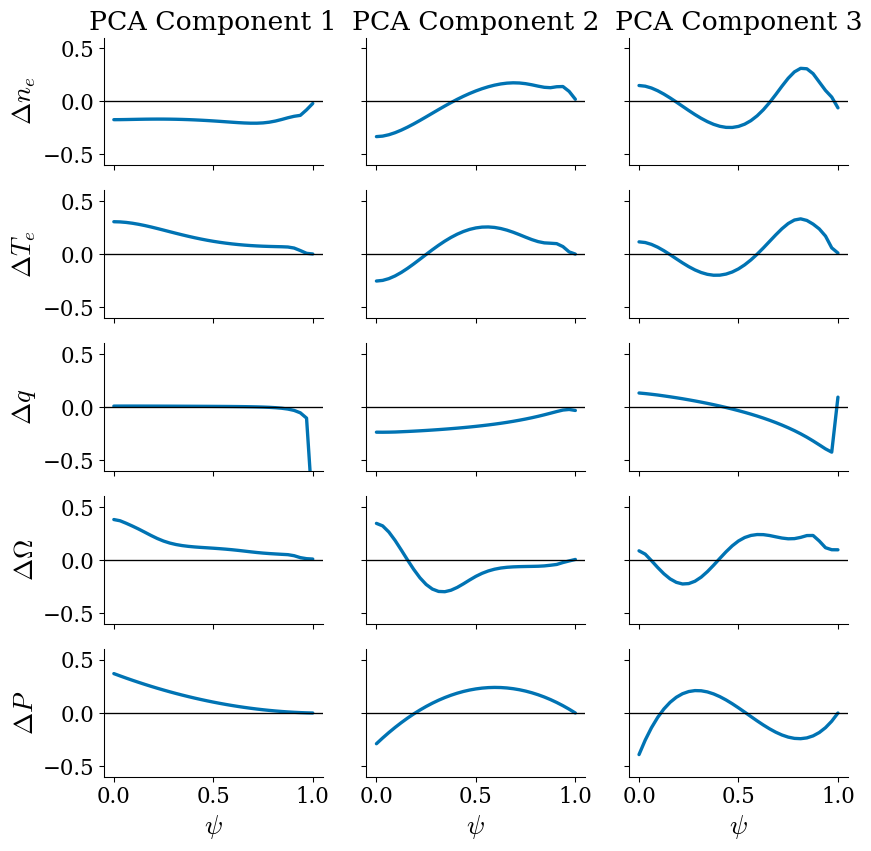

In [79]:
"""plot pca modes"""

ncols = 5
nrows = 3
ylabels = ['$\Delta n_e$','$\Delta  T_e$','$\Delta  q$','$\Delta  \Omega$','$\Delta  P$']
fig, axes = plt.subplots(5,3, sharex=True, sharey=True,figsize=(10,10))
for j,profile in enumerate(profiles):
    pca=pca_fitter[profile]
    for i in range(nrows):
        ax= axes[j,i]
        ax.plot(psi,pca.components_[i])
        if i==0:
            ax.set_ylabel(ylabels[j], size=20)
        if j==0:
            ax.set_title('PCA Component {}'.format(i+1), size=20)
        if j==4:
            ax.set_xlabel('$\psi$',size=20)
        ax.set_ylim(-.6,.6)
        ax.tick_params(axis='both', which='major', labelsize=16)

        ax.axhline(0,c='k',lw=1)
fig.savefig('pca_modes.png')

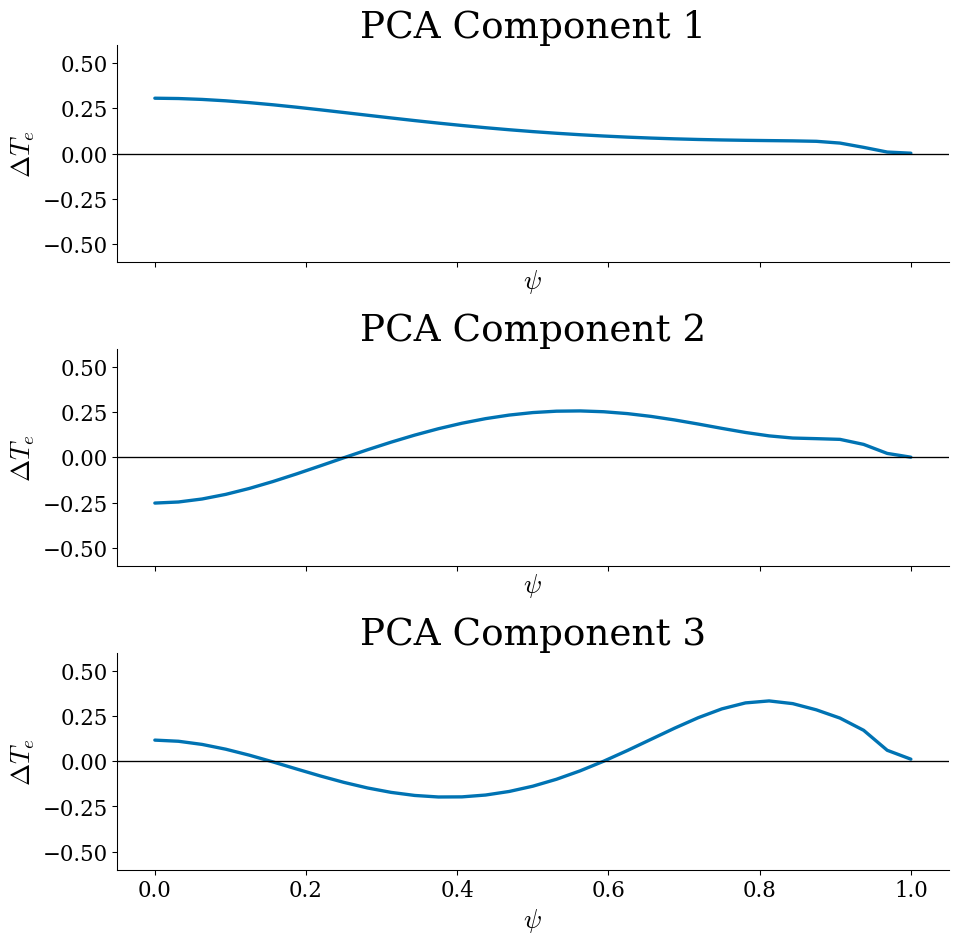

In [80]:
"""plot pca mode"""

ncols = 1
nrows = 3
ylabels = ['$\Delta n_e$','$\Delta  T_e$','$\Delta  q$','$\Delta  \Omega$','$\Delta  P$']
fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=True,figsize=(10,10))
for j,profile in enumerate(profiles):
    if j != 1:
        continue
    pca=pca_fitter[profile]
    for i in range(nrows):
        ax= axes[i]
        ax.plot(psi,pca.components_[i])
        ax.set_ylabel(ylabels[j], size=20)
        ax.set_title('PCA Component {}'.format(i+1), size=28)
        ax.set_xlabel('$\psi$',size=20)
        ax.set_ylim(-.6,.6)
        ax.tick_params(axis='both', which='major', labelsize=16)

        ax.axhline(0,c='k',lw=1)
plt.subplots_adjust(hspace=.5)
plt.tight_layout()
fig.savefig('pca_mode.png')

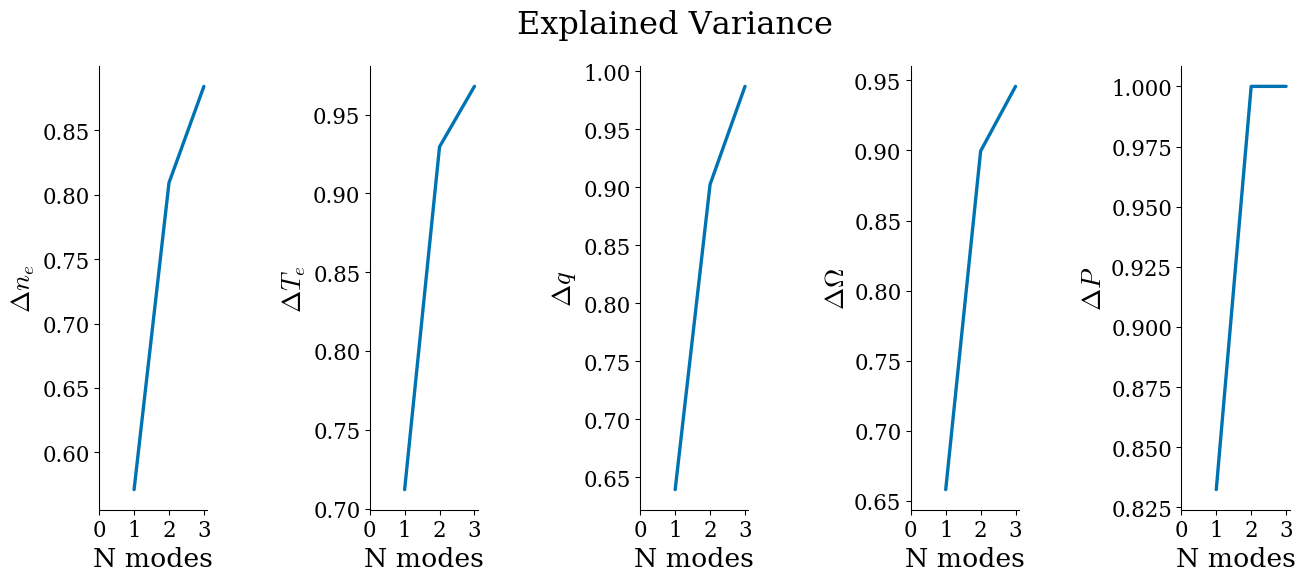

In [43]:
"""plot explained variance"""

fig, axes = plt.subplots(1,5,sharey=False,figsize=(16,6))
for j,profile in enumerate(profiles):
    pca=pca_fitter[profile]
    ax = axes[j]
    
    ax.plot([1,2,3],np.cumsum(pca.explained_variance_ratio_))
    ax.set_ylabel(ylabels[j],size=20)
    ax.set_xlabel('N modes', size=20)
    ax.set_xticks([0,1,2,3])
    ax.tick_params(axis='both', which='both', labelsize=16)
#     ax.set_yscale('log')

#     ax.set_ylim((10**-3,100))
#     ax.axhline(0,c='k')
fig.suptitle('Explained Variance', size=24)
plt.subplots_adjust(wspace=1.5)
fig.savefig('explained_variance.png')

In [16]:
[0,*pca.explained_variance_ratio_]

[0, 0.8654949193760256, 0.13450506770279502, 1.2921064990985718e-08]

# Average performance #

In [45]:
import time
begin_time=time.time()

plt.rcParams["figure.figsize"] = (30,20)

psi = np.linspace(0,1,scenario['profile_length'])
sigs=scenario['actuator_names']
profiles=scenario['target_profile_names']
input_profiles=scenario['input_profile_names']

sig_lims={'thomson_temp_EFITRT1': [0,2e3],    
          'rotation': {'mean': [-120,120], 'std': [0,100], 'pca 1': [-800,800], 'pca 2': [-250,250], 'pca 3': [-150,150]},
          'q_EFIT01': {'mean': [-1.5,1.5], 'std': [0,1], 'pca 1': [-12,12], 'pca 2': [-5,5], 'pca 3': [-5,5]},
          'press_EFIT01': {'mean': [-50000,50000], 'std': [0,50000], 'pca 1': [-300000,300000], 'pca 2': [-60000,60000], 'pca 3': [-50000,50000]},
          'temp': {'mean': [-1.8,1.8], 'std': [0,1], 'pca 1': [-15,15], 'pca 2': [-5,5], 'pca 3': [-5,5]}, 
          'dens': {'mean': [-2.5,2.5], 'std': [0,2], 'pca 1': [-20,20], 'pca 2': [-8,8], 'pca 3': [-8,8]},
          'pinj': [0,1.5e4],
          'tinj':[0,10],
          'target_density': [0,8],
          'gasA': [0,10]}

average_change=np.zeros((len(sigs),len(profiles),len(psi)))
std_change=np.zeros((len(sigs),len(profiles),len(psi)))

denormalized=False
perturbation_size=.1

num_samples = 1000 #len(train_generator)
    
def scalarize_mean(arr, **kwargs):
    return np.mean(arr)

def scalarize_std(arr, **kwargs):
    return np.std(arr)

def scalarize_pca_1(arr, **kwargs):
    # PCA of changes:
    #ret = pca_fitter[profile].transform([arr.squeeze()]).squeeze()[0]
    # raw PCA: 
    next_profile=kwargs['prev_profile'].squeeze()+arr.squeeze()
    ret = pca_fitter[profile].transform([next_profile]).squeeze()[0]
    return ret

def scalarize_pca_2(arr, **kwargs):
    # PCA of changes:
    #ret = pca_fitter[profile].transform([arr.squeeze()]).squeeze()[1]
    # raw PCA: 
    next_profile=kwargs['prev_profile'].squeeze()+arr.squeeze()
    ret = pca_fitter[profile].transform([next_profile]).squeeze()[1]
    return ret

def scalarize_pca_3(arr, **kwargs):
    # PCA of changes:
    #ret = pca_fitter[profile].transform([arr.squeeze()]).squeeze()[2]
    # raw PCA: 
    next_profile=kwargs['prev_profile'].squeeze()+arr.squeeze()
    ret = pca_fitter[profile].transform([next_profile]).squeeze()[2]
    return ret

#for k in range(num_samples):
scalarize_functions=[scalarize_mean,scalarize_pca_1,scalarize_pca_2, scalarize_pca_3]
scalarize_function_names=['mean','pca 1','pca 2', 'pca 3']

true_profile=np.zeros((len(scalarize_functions),len(profiles),num_samples))
predicted_profile=np.zeros((len(scalarize_functions),len(profiles),num_samples))

k=0
for k in tqdm(range(num_samples-1)):
    
    index=np.random.choice(len(train_generator))
    #index=k
    sample=train_generator[index]
    inputs=sample[0]
    targets=sample[1]
    
    # only include if mean change in standardized profiles is greater than .1 for at least one profile
    skip=np.zeros(len(profiles))
    for j,profile in enumerate(profiles):
        target=targets['target_{}'.format(profile)][0]
        if abs(np.mean(target))<.1:
            skip[j]=1
    if all(skip):
        continue
    else:
        k+=1
    predictions=model.predict_on_batch(inputs)

    for j,profile in enumerate(profiles):
        target=targets['target_{}'.format(profile)][0]
        if denormalized:
            #predicted_profile[i][j][k]=normalize(predicted_profile[i][j][k],profile) 
            #true_profile[i][j][k]=normalize(true_profile[i][j][k],profile)
            predictions[j]=normalize(predictions[j],profile) 
            target=normalize(target,profile)
        for i,scalarize in enumerate(scalarize_functions):
            #true_profile[i][j][k]=scalarize(target,profile)
            #predicted_profile[i][j][k]=scalarize(predictions[j],profile)
            true_profile[i][j][k]=scalarize(target,profile=profile, prev_profile=inputs['input_{}'.format(profile)])
            predicted_profile[i][j][k]=scalarize(predictions[j],profile=profile, prev_profile=inputs['input_{}'.format(profile)])
#     k += 1

            

print(time.time()-begin_time)


145.2734339237213


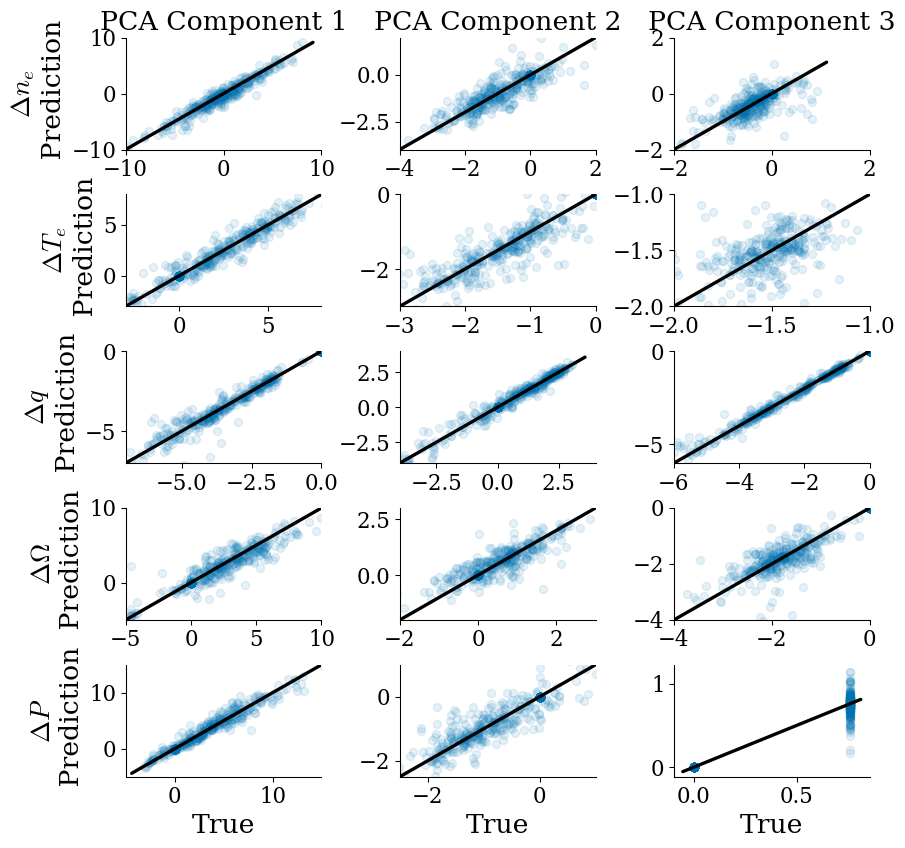

In [76]:
fig, axes = plt.subplots(5,3, figsize=(10,10))
ylabels = ['$\Delta n_e$','$\Delta T_e$','$\Delta q$','$\Delta \Omega$','$\Delta P$']

for i,profile in enumerate(profiles):
    for j,scalarize_name in enumerate(scalarize_function_names):
        if j==0:
            continue
        pred=predicted_profile[j][i]
        true=true_profile[j][i]
        
        ax = axes[i,j-1]
        if i==0:
            ax.set_title('PCA Component {}'.format(j),size=20)
        
        # 1-1 plot:
        ax.scatter(true_profile[j][i],predicted_profile[j][i],alpha=0.1)
        
        # for raw
        x_45 = np.linspace(*ax.get_xlim())
        ax.plot(x_45, x_45,color='k')
        if i==4:
            ax.set_xlabel('True',size=20)
        if j==1:
            ax.set_ylabel(ylabels[i] +  '\n Prediction', size=20)
        ax.tick_params(axis='both', which='major', labelsize=16)

axes[0,0].set_ylim((-10,10))
axes[0,0].set_xlim((-10,10))
axes[0,1].set_ylim((-4,2))
axes[0,1].set_xlim((-4,2))
axes[0,2].set_ylim((-2,2))
axes[0,2].set_xlim((-2,2))
axes[1,0].set_ylim((-3,8))
axes[1,0].set_xlim((-3,8))
axes[1,1].set_ylim((-3,0))
axes[1,1].set_xlim((-3,0))
axes[1,2].set_ylim((-2,-1))
axes[1,2].set_xlim((-2,-1))
axes[2,0].set_ylim((-7,0))
axes[2,0].set_xlim((-7,0))
axes[2,1].set_ylim((-4,4))
axes[2,1].set_xlim((-4,4))
axes[2,2].set_ylim((-6,0))
axes[2,2].set_xlim((-6,0))
axes[3,0].set_ylim((-5,10))
axes[3,0].set_xlim((-5,10))
axes[3,1].set_ylim((-2,3))
axes[3,1].set_xlim((-2,3))
axes[3,2].set_ylim((-4,0))
axes[3,2].set_xlim((-4,0))
axes[4,0].set_ylim((-5,15))
axes[4,0].set_xlim((-5,15))
axes[4,1].set_ylim((-2.5,1))
axes[4,1].set_xlim((-2.5,1))
# axes[4,2].set_ylim((0.7,0.8))
# axes[4,2].set_xlim((0.7,0.8))
plt.subplots_adjust(hspace=.4,wspace=.4)
fig.savefig('pca_acc.png')

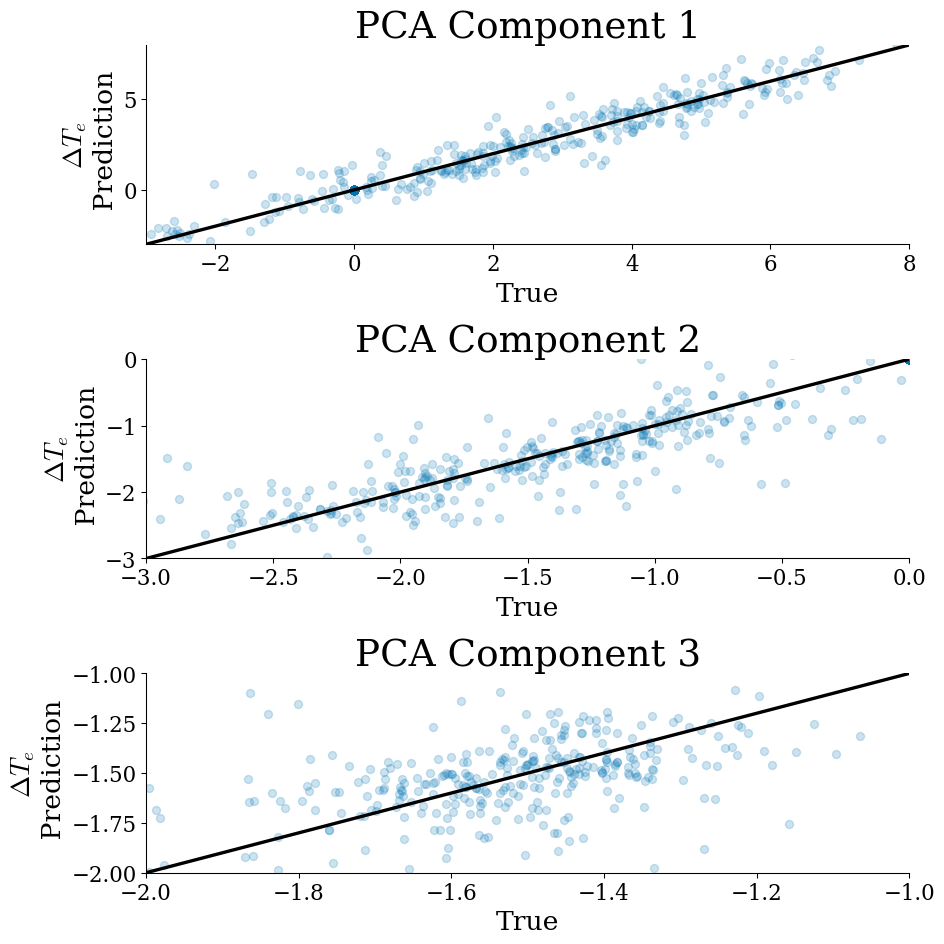

In [81]:
fig, axes = plt.subplots(3,1, figsize=(10,10))
ylabels = ['$\Delta n_e$','$\Delta T_e$','$\Delta q$','$\Delta \Omega$','$\Delta P$']

for i,profile in enumerate(profiles):
    for j,scalarize_name in enumerate(scalarize_function_names):
        if j==0:
            continue
        if i != 1:
            continue
        pred=predicted_profile[j][i]
        true=true_profile[j][i]
        
        ax = axes[j-1]
        ax.set_title('PCA Component {}'.format(j),size=28)
        
        # 1-1 plot:
        ax.scatter(true_profile[j][i],predicted_profile[j][i],alpha=0.2)
        
        # for raw
        x_45 = np.linspace(*ax.get_xlim())
        ax.plot(x_45, x_45,color='k')
        ax.set_xlabel('True',size=20)
        ax.set_ylabel(ylabels[i] +  '\n Prediction', size=20)
        ax.tick_params(axis='both', which='major', labelsize=16)

axes[0].set_ylim((-3,8))
axes[0].set_xlim((-3,8))
axes[1].set_ylim((-3,0))
axes[1].set_xlim((-3,0))
axes[2].set_ylim((-2,-1))
axes[2].set_xlim((-2,-1))

plt.subplots_adjust(hspace=.6)
plt.tight_layout()
fig.savefig('pca_acc_te.png')

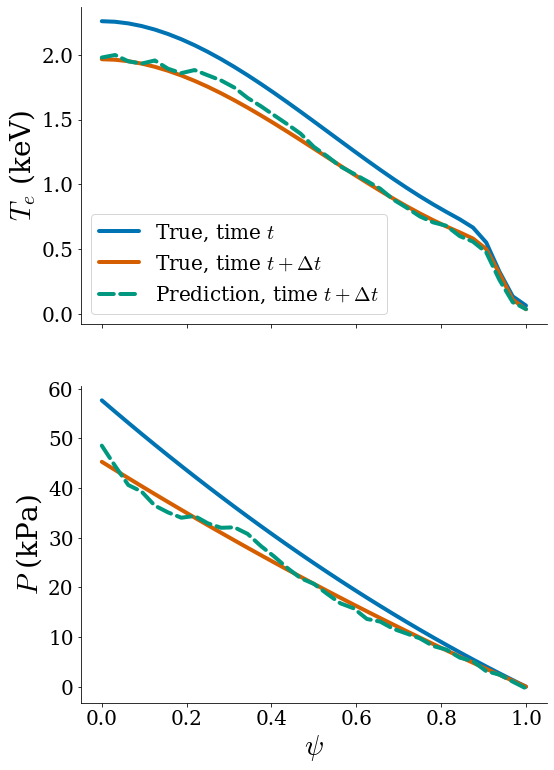

In [239]:
# for k in range(len(train_generator)):
    
#     index=k #np.random.choice(len(train_generator))
#     #index=k
#     sample=train_generator[index]
#     inputs=sample[0]
#     targets=sample[1]
#     predictions=model.predict_on_batch(inputs)
#     # only include if mean change in standardized profiles is greater than .1 for at least one profile
#     skip=np.zeros(len(profiles))
#     for j,profile in enumerate(profiles):
#         target=targets['target_{}'.format(profile)].squeeze()
#         pred = predictions[j].squeeze()
#         if np.mean(abs(target))<.1 or np.mean(abs(target-pred))>0.01:
#             skip[j]=1
#     if all(skip):
#         continue
#     else:
#         print(index)
#         break

index = 94117
inputs, targets,_ = train_generator[index]

predictions=model.predict_on_batch(inputs)
ylabels = ['$n_e$','$T_e$ (keV)','$q$','$\Omega$','$P$ (kPa)']

fig, axes = plt.subplots(2,1,sharex=True, figsize=(9,12))
k=0
for j, profile in enumerate(profiles):
    if j in (1,4):
        ax = axes[k]
        inp = inputs['input_{}'.format(profile)].squeeze()
        true_delta = inputs['input_{}'.format(profile)].squeeze() + targets['target_{}'.format(profile)].squeeze()
        pred_delta = inputs['input_{}'.format(profile)].squeeze() + predictions[j].squeeze()

        inp = helpers.normalization.denormalize_arr(inp,normalization_dict[profile])
        true_delta = helpers.normalization.denormalize_arr(true_delta,normalization_dict[profile])
        pred_delta = helpers.normalization.denormalize_arr(pred_delta,normalization_dict[profile])
        if k==1:
            inp /= 1000
            true_delta /= 1000
            pred_delta /= 1000
        ax.plot(psi,inp,lw=4,label='True, time $t$')
        ax.plot(psi,true_delta,lw=4,label='True, time $t+\Delta t$')
        ax.plot(psi,pred_delta,lw=4,ls='--',label='Prediction, time $t+\Delta t$')
        ax.set_ylabel(ylabels[j],size=28)
        if k==1:
            ax.set_xlabel('$\psi$',size=28)
        if k==0:
            ax.legend(fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        k +=1
plt.tight_layout()
fig.savefig('prof_pred_ex.png')

80473


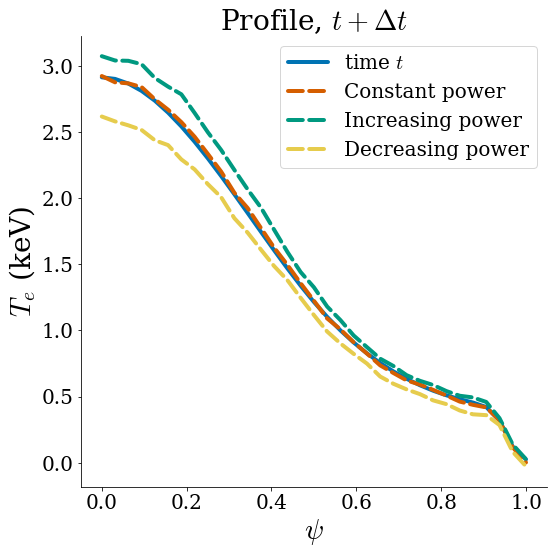

In [300]:
import copy
index = 80473 #np.random.choice(len(train_generator))
print(index)
inputs, targets,_ = train_generator[index]
inp_const = copy.copy(inputs)
inp_const['input_future_pinj'] = np.ones((1,4))*inputs['input_past_pinj'].squeeze()[-1]

inp_inc = copy.copy(inputs)
inp_inc['input_future_pinj'] = np.ones((1,4))*inputs['input_past_pinj'].squeeze()[-1] + 0.5

inp_dec = copy.copy(inputs)
inp_dec['input_future_pinj'] = np.ones((1,4))*inputs['input_past_pinj'].squeeze()[-1] - 0.5

pred_const = model.predict_on_batch(inp_const)
pred_inc = model.predict_on_batch(inp_inc)
pred_dec = model.predict_on_batch(inp_dec)

ylabels = ['$n_e$','$T_e$ (keV)','$q$','$\Omega$','$P$ (kPa)']

fig, ax = plt.subplots(1,1,figsize=(9,9))

j = 1
profile = profiles[j]

inp = inputs['input_{}'.format(profile)].squeeze()
pred_const = inp + pred_const[j].squeeze()
pred_inc = inp + pred_inc[j].squeeze()
pred_dec = inp + pred_dec[j].squeeze()

inp = helpers.normalization.denormalize_arr(inp,normalization_dict[profile])
pred_const = helpers.normalization.denormalize_arr(pred_const,normalization_dict[profile])
pred_inc = helpers.normalization.denormalize_arr(pred_inc,normalization_dict[profile])
pred_dec = helpers.normalization.denormalize_arr(pred_dec,normalization_dict[profile])


ax.plot(psi,inp,lw=4,label='time $t$')
ax.set_ylabel(ylabels[j],size=28)
ax.set_xlabel('$\psi$',size=28)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Profile, $t+\Delta t$', size=28)
plt.tight_layout()
fig.savefig('prof_act_scan0.png') 

ax.plot(psi,pred_const,lw=4,ls='--',color=colorblind_colors[1], label='Constant power')
ax.legend(fontsize=20)
fig.savefig('prof_act_scan1.png')

ax.plot(psi,pred_inc,lw=4,ls='--',color=colorblind_colors[2], label='Increasing power')
ax.legend(fontsize=20)
fig.savefig('prof_act_scan2.png')

ax.plot(psi,pred_dec,lw=4,ls='--',color=(0.900, 0.800, 0.300), label='Decreasing power')
ax.legend(fontsize=20)
fig.savefig('prof_act_scan3.png')



In [268]:
inputs['input_future_pinj'].shape

(1, 4)